In [ ]:
# Md. Shakhawat Hossain
# Bachelor of Science in Computer Science and Engineering (BSCSE)
# Department of Electrical and Computer Engineering
# North South University
# Plot # 15, Block # B, Bashundhara
# Dhaka – 1229, Bangladesh
# Gmail: shakhawat.hossain07.edu@gmail.com

# Install necessary libraries
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=ba8863ca8e9543a4d1754048e5859719592b5ae554de0253b44abc73f5f7616c
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
from imblearn.over_sampling import ADASYN
from google.colab import drive
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the root directory of the dataset
root_dir = "/content/drive/MyDrive/Oral Disease Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define a function to create a DataFrame with image paths and labels from the dataset
def create_dataframe(root_dir):
    data = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg'):
                label = os.path.basename(subdir)
                data.append([os.path.join(subdir, file), label])
    return pd.DataFrame(data, columns=['image_path', 'label'])

In [ ]:
# Load dataset information into a DataFrame
data_df = create_dataframe(root_dir)
data_df['label'] = data_df['label'].astype('category').cat.codes
data_df.dropna(inplace=True)


In [ ]:
# Check unique classes and class distribution
print("Unique classes in the dataset:", data_df['label'].unique())
print("Class distribution:\n", data_df['label'].value_counts())

Unique classes in the dataset: [0 1]
Class distribution:
 label
0    1306
1     219
Name: count, dtype: int64


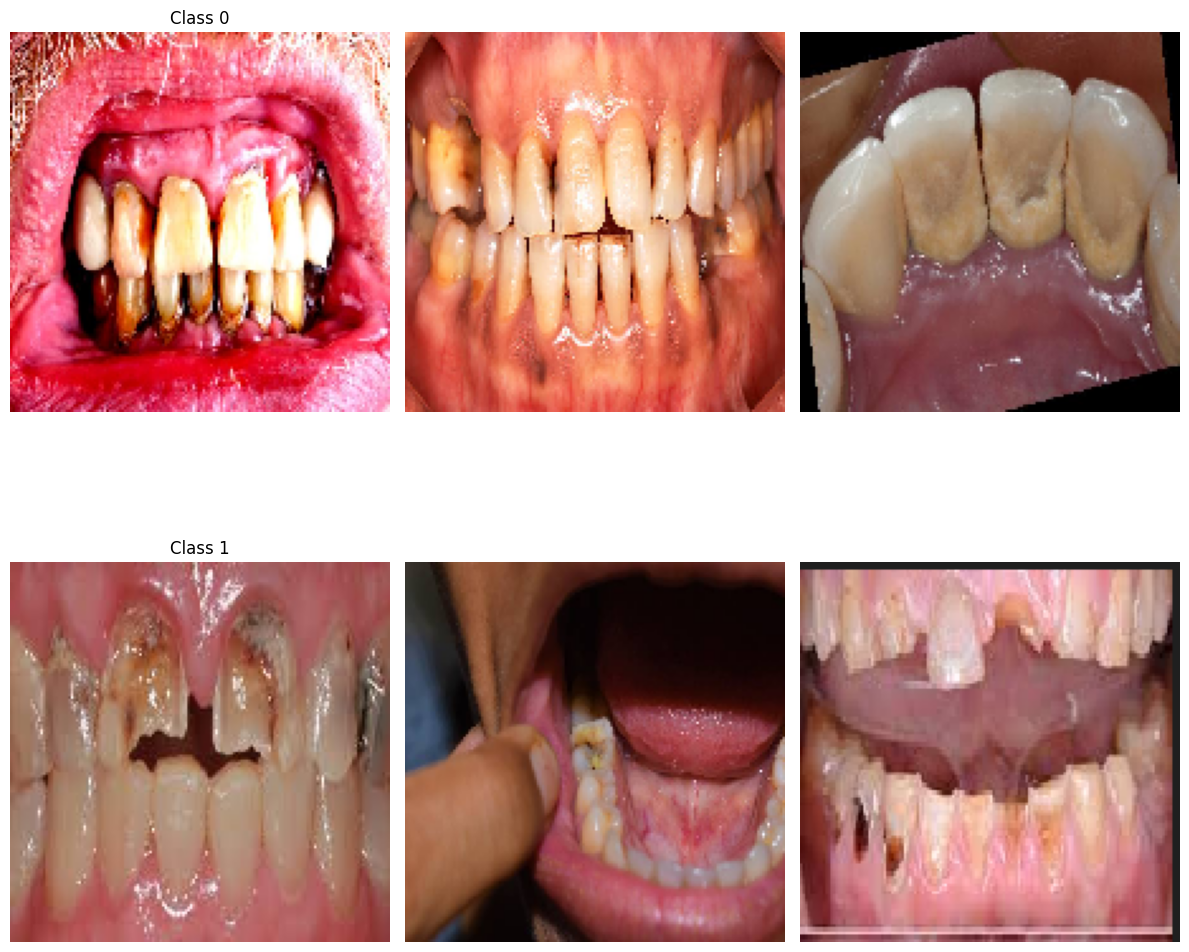

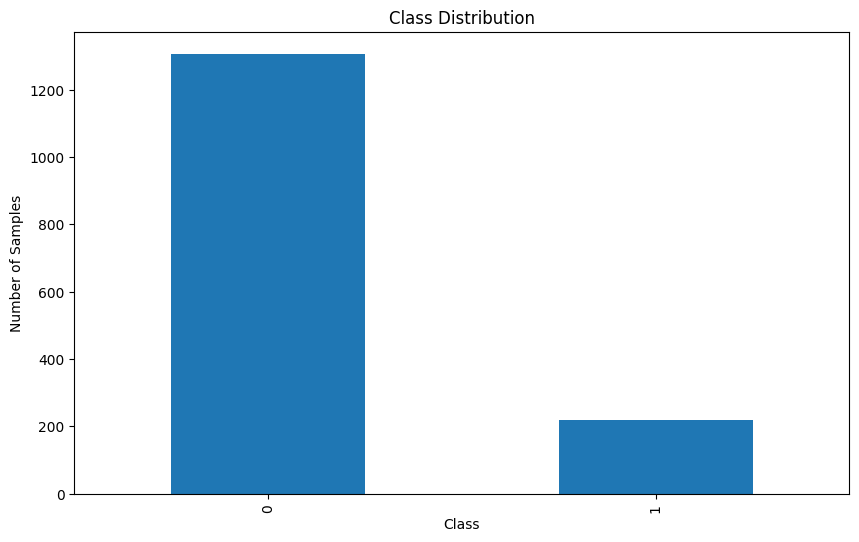

In [ ]:

# Function to plot sample images from each class
def plot_sample_images(data_df, n_samples=3, target_size=(150, 150)):
    classes = data_df['label'].unique()
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(12, 12))

    for idx, cls in enumerate(classes):
        sample_paths = data_df[data_df['label'] == cls]['image_path'].sample(n=n_samples).tolist()
        for i, image_path in enumerate(sample_paths):
            img = load_img(image_path, target_size=target_size)
            axes[idx, i].imshow(img)
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f"Class {cls}")

    plt.tight_layout()
    plt.show()

# Function to plot class distribution
def plot_class_distribution(data_df):
    class_counts = data_df['label'].value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot sample images
plot_sample_images(data_df)

# Plot class distribution
plot_class_distribution(data_df)

In [ ]:
# Define a function to load and resize images
def load_and_resize_images(image_paths, target_size=(150, 150)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

In [ ]:
# Load images into arrays and labels into a NumPy array
X_images = load_and_resize_images(data_df['image_path'])
y_labels = data_df['label'].values

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert data to PyTorch tensors and reshape
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Check tensor shapes
print(f"Shape of X_train_tensor: {X_train_tensor.shape}")
print(f"Shape of y_train_tensor: {y_train_tensor.shape}")
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
print(f"Shape of y_test_tensor: {y_test_tensor.shape}")

Shape of X_train_tensor: torch.Size([1220, 3, 150, 150])
Shape of y_train_tensor: torch.Size([1220])
Shape of X_test_tensor: torch.Size([305, 3, 150, 150])
Shape of y_test_tensor: torch.Size([305])


In [ ]:
# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Counts: {'1': 100}


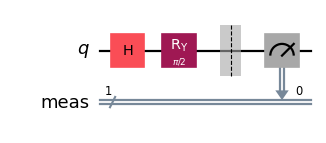

In [ ]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer

class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

        # Define the circuit
        self.circuit = QuantumCircuit(n_qubits)
        self.theta = Parameter("theta")
        self.circuit.h(0)
        self.circuit.ry(self.theta, 0)
        self.circuit.measure_all()

    def run(self, theta):
        # Ensure theta is passed correctly
        if isinstance(theta, (list, np.ndarray)):
            theta = theta[0]

        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, self.backend)

        # Execute the job using the BackendV2 interface
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        # Calculate expectation value
        counts_array = np.array(list(counts.values()))
        states_array = np.array([int(state, 2) for state in counts.keys()])
        probabilities = counts_array / self.shots
        expectation = np.sum(states_array * probabilities)

        return np.array([expectation])

    def draw_circuit(self, theta): # Corrected indentation
        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, AerSimulator())

        # Execute the job using the AerSimulator
        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        # Print the counts
        print("Counts:", counts)

        # Draw the circuit and show the plot
        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

# Initialize the quantum circuit and plot it
quantum_circuit = MyQuantumCircuit(1, AerSimulator(), 100)
quantum_circuit.draw_circuit(np.pi / 2)

In [ ]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []

        for sample in input:
            # Run quantum circuit for each input
            expectation_z.append(ctx.quantum_circuit.run([sample.item()]))

        result = torch.tensor(expectation_z, dtype=torch.float32)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, _ = ctx.saved_tensors
        input_list = input.tolist()

        # Compute gradients using parameter shift
        gradients = []
        for i in range(len(input_list)):
            shift_right = input_list[i] + ctx.shift
            shift_left = input_list[i] - ctx.shift
            expectation_right = ctx.quantum_circuit.run([shift_right])
            expectation_left = ctx.quantum_circuit.run([shift_left])
            gradient = (expectation_right - expectation_left) / (2 * ctx.shift)
            gradients.append(gradient)

        gradients = torch.tensor(gradients, dtype=torch.float32)
        return gradients * grad_output, None, None


In [ ]:
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyQuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
# Define the CNN Model with Quantum Layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d()
        self.hybrid = Hybrid(AerSimulator(), 100, np.pi / 2)

        # Dynamically calculate flattened input size
        self._flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self._flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        return int(np.prod(x.size()))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)  # Single value per sample for hybrid layer
        hybrid_output = torch.stack([self.hybrid(sample.unsqueeze(0)) for sample in x])  # Batch processing
        return hybrid_output.view(-1, 1)  # Ensure output shape matches target

In [ ]:
# Initialize model, optimizer, and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unique classes in the dataset: [1 0]
Class distribution:
 label
0    1296
1     183
Name: count, dtype: int64
Shape of X_train_tensor: torch.Size([1183, 3, 150, 150])
Shape of y_train_tensor: torch.Size([1183])
Shape of X_test_tensor: torch.Size([296, 3, 150, 150])
Shape of y_test_tensor: torch.Size([296])
Epoch 1/20, Loss: 1.8495
Epoch 2/20, Loss: 0.7209
Epoch 3/20, Loss: 0.5629
Epoch 4/20, Loss: 0.5620
Epoch 5/20, Loss: 0.5565
Epoch 6/20, Loss: 0.5476
Epoch 7/20, Loss: 0.5398
Epoch 8/20, Loss: 0.5423
Epoch 9/20, Loss: 0.5269
Epoch 10/20, Loss: 0.5247
Epoch 11/20, Loss: 0.5224
Epoch 12/20, Loss: 0.5096
Epoch 13/20, Loss: 0.5040
Epoch 14/20, Loss: 0.5036
Epoch 15/20, Loss: 0.5026
Epoch 16/20, Loss: 0.5020
Epoch 17/20, Loss: 0.4925
Epoch 18/20, Loss: 0.4891
Epoch 19/20, Loss: 0.4796
Epoch 20/20, Loss: 0.4840


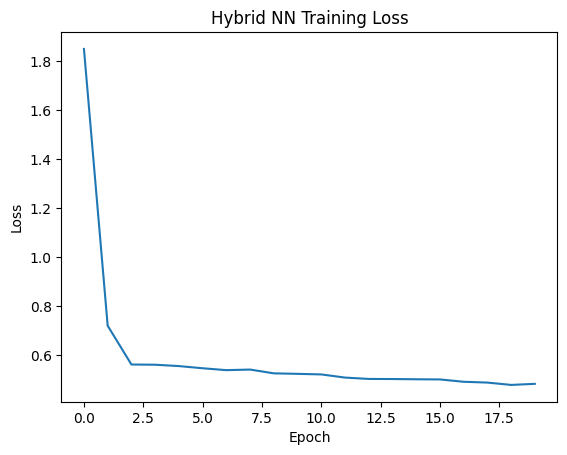

In [ ]:
# Training loop
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_list[-1]:.4f}")

# Plot training loss
plt.plot(loss_list)
plt.title('Hybrid Quantum Classical Nural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate model
model.eval()
correct = 0
total_loss = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = (output > 0.5).int()  # Binary classification threshold
        correct += (pred == target.view(-1, 1)).sum().item()
        loss = loss_func(output, target.float().view(-1, 1))
        total_loss.append(loss.item())

avg_loss = sum(total_loss) / len(total_loss)
accuracy = correct / len(test_loader.dataset) * 100

print(f"Average Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
# Function to evaluate model and print detailed classification report
def evaluate_model(model, test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = (output > 0.5).int()  # Binary classification threshold
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    auroc = roc_auc_score(y_true, y_pred)

    report = {
        'Accuracy': accuracy,
        'Macro-F1': macro_f1,
        'Precision': precision,
        'Recall': recall,
        'AUROC': auroc
    }

    return report

# Evaluate the model
eval_report = evaluate_model(model, test_loader)

# Print the evaluation report
print("Evaluation Report:")
for metric, score in eval_report.items():
    print(f"{metric}: {score:.4f}")

# Collect data for the model
models_data = {
    'Model': ['HQCNN'],
    'Accuracy': [eval_report['Accuracy']],
    'Macro-F1': [eval_report['Macro-F1']],
    'Precision': [eval_report['Precision']],
    'Recall': [eval_report['Recall']],
    'AUROC': [eval_report['AUROC']]
}

results_df = pd.DataFrame(models_data)

print("Results Table:")
print(results_df)


Evaluation Report:
Accuracy: 0.8873
Macro-F1: 0.5007
Precision: 0.3333
Recall: 0.0323
AUROC: 0.5124
Results Table:
   Model  Accuracy  Macro-F1  Precision    Recall     AUROC
0  HQCNN  0.887258  0.500738   0.333333  0.032258  0.512355
